In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

In [2]:
data=pd.read_csv('Power-Networks-LCL.csv')
data.head()

,LCLid,stdorToU,DateTime,KWh,Acorn,Acorn_grouped
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0.0,ACORN-A,Affluent
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0.0,ACORN-A,Affluent
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0.0,ACORN-A,Affluent
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0.0,ACORN-A,Affluent
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0.0,ACORN-A,Affluent


In [3]:
top_3 = data['LCLid'].value_counts().sort_values(ascending = False).head(3)

In [4]:
new_data = pd.DataFrame()
for i in top_3.index:
    j = str(i)
    new_data = new_data.append(data[data['LCLid']== i])

In [5]:
new_data['LCLid'].unique()

array(['MAC000018', 'MAC000020', 'MAC000021'], dtype=object)

In [6]:
data = new_data
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.head()

,LCLid,stdorToU,DateTime,KWh,Acorn,Acorn_grouped
326612,MAC000018,Std,2011-12-07 09:30:00,0.303,ACORN-E,Affluent
326613,MAC000018,Std,2011-12-07 10:00:00,0.200,ACORN-E,Affluent
326614,MAC000018,Std,2011-12-07 10:30:00,0.218,ACORN-E,Affluent
326615,MAC000018,Std,2011-12-07 11:00:00,0.209,ACORN-E,Affluent
326616,MAC000018,Std,2011-12-07 11:30:00,0.210,ACORN-E,Affluent


In [7]:
data['LCLid'].value_counts()

MAC000018    39081
MAC000021    39078
MAC000020    39078
Name: LCLid, dtype: int64

In [8]:
db_1 = data[data['LCLid']== top_3.index[0]]
db_2 = data[data['LCLid']== top_3.index[1]]
db_3 = data[data['LCLid']== top_3.index[2]]


In [9]:
db_1['LCLid'].value_counts()

MAC000018    39081
Name: LCLid, dtype: int64

In [10]:
db_2['LCLid'].value_counts()

MAC000020    39078
Name: LCLid, dtype: int64

In [11]:
db_3['LCLid'].value_counts()

MAC000021    39078
Name: LCLid, dtype: int64

In [12]:
db_1.drop(['LCLid', 'Acorn','Acorn_grouped','stdorToU'],axis = 1,inplace=True)
db_2.drop(['LCLid', 'Acorn','Acorn_grouped','stdorToU'],axis = 1,inplace=True)
db_3.drop(['LCLid', 'Acorn','Acorn_grouped','stdorToU'],axis = 1,inplace=True)

C:\Users\dhara\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [13]:
def plotGraph(data):
    plt.figure(figsize=(25,15))
    plt.xlabel('Time')
    plt.ylabel('Power Used')
    plt.plot(db_1_day)

In [14]:
from statsmodels.tsa.stattools import adfuller

def testForStationarity(data):
    movingAverage = data.rolling(window = 365).mean()
    movingSTD = data.rolling(window = 365).std()
    
    plt.figure(figsize=(25,15))
    original = plt.plot(data,color = 'blue',label = 'HouseHold')
    mean = plt.plot(movingAverage, color = 'black',label = 'Rolling Mean')
    std = plt.plot(movingSTD, color = 'red', label = 'Rolling Std')
    plt.show(block = False)
    
    dfTest = adfuller(data['KWh'], autolag = 'AIC')
    dfOutput = pd.Series(dfTest[0:4], index = ['Test Stastic','p_value','Lags','No of observations'])
    for key,value in dfTest[4].items():
        dfOutput['Critical Value (%s)'%key] = value
    print(dfOutput)


In [39]:
def transformingToStationary(data):
    logSeries_data = np.log(data)
    movingAverage = logSeries_data.rolling(window = 365).mean()
    plt.plot(movingAverage)
    plt.plot(logSeries_data, color = 'black')
    plt.show()
    
    dataLogScaleMinusMovingAverage = logSeries_data - movingAverage
    dataLogScaleMinusMovingAverage.dropna(inplace = True)
    testForStationarity(dataLogScaleMinusMovingAverage)
    
    exponentialDecayWeightedAverage = logSeries_data.ewm(halflife = 365,min_periods = 0, adjust = True).mean()
    plt.plot(logSeries_data)
    plt.plot(exponentialDecayWeightedAverage)
    plt.show()
    
    logScaleMinusexponentialDecayWeightedAverage = logSeries_data - exponentialDecayWeightedAverage
    print("Hello")
    testForStationarity(logScaleMinusexponentialDecayWeightedAverage)
    
    logScaleShifting = logSeries_data - logSeries_data.shift()
    plt.plot(logScaleShifting)
    plt.show()
    logScaleShifting.dropna(inplace = True)
    testForStationarity(logScaleShifting)
    #print(logScaleShifting)
    return logScaleShifting
    
    
    

In [50]:
def predictionBlock(data):
    model = ARIMA(data, order=(5,1,0))
    model_fit = model.fit(disp=0)
    
    train, test = data[0:3030], data[3030:len(data)]
    values = [i for i in train]
    prediction = []
    for t in range(len(test)):
        model_t = ARIMA(values, order=(5,1,0))
        model_fit_t = model_t.fit(disp=0)
        output_t = model_fit_t.forecast()
        yhat_t = output_t[0]
        prediction.append(yhat_t)
        obs_t = test_t[t]
        values.append(obs_18)
    pyplot.plot(test_,label='Actual')
    pyplot.plot(predictions, color='red',label='ForeCasted')
    plt.legend()
    plt.title("Energy usage in kwh for household'", fontsize=14, fontstyle='italic', fontweight='bold')
    pyplot.show()
    

In [15]:
db_1['Date'] = db_1['DateTime'].dt.date
db_1_copy = db_1.copy()
db_1_day = db_1.groupby('Date')
db_1_day = db_1_day.sum()
db_1_day.head()


C:\Users\dhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,KWh
Date,
2011-12-07,10.040
2011-12-08,18.445
2011-12-09,15.911
2011-12-10,17.666
2011-12-11,18.674


In [16]:
db_2['Date'] = db_2['DateTime'].dt.date
db_2_copy = db_2.copy()
db_2_day = db_2.groupby('Date')
db_2_day = db_2_day.sum()
db_2_day.head()

C:\Users\dhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,KWh
Date,
2011-12-07,6.153
2011-12-08,7.330
2011-12-09,6.184
2011-12-10,8.763
2011-12-11,10.810


In [17]:
db_3['Date'] = db_3['DateTime'].dt.date
db_3_copy = db_3.copy()
db_3_day = db_3.groupby('Date')
db_3_day = db_3_day.sum()
db_3_day.head()

C:\Users\dhara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,KWh
Date,
2011-12-07,18.361
2011-12-08,26.788
2011-12-09,24.606
2011-12-10,19.130
2011-12-11,25.739


C:\Users\dhara\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


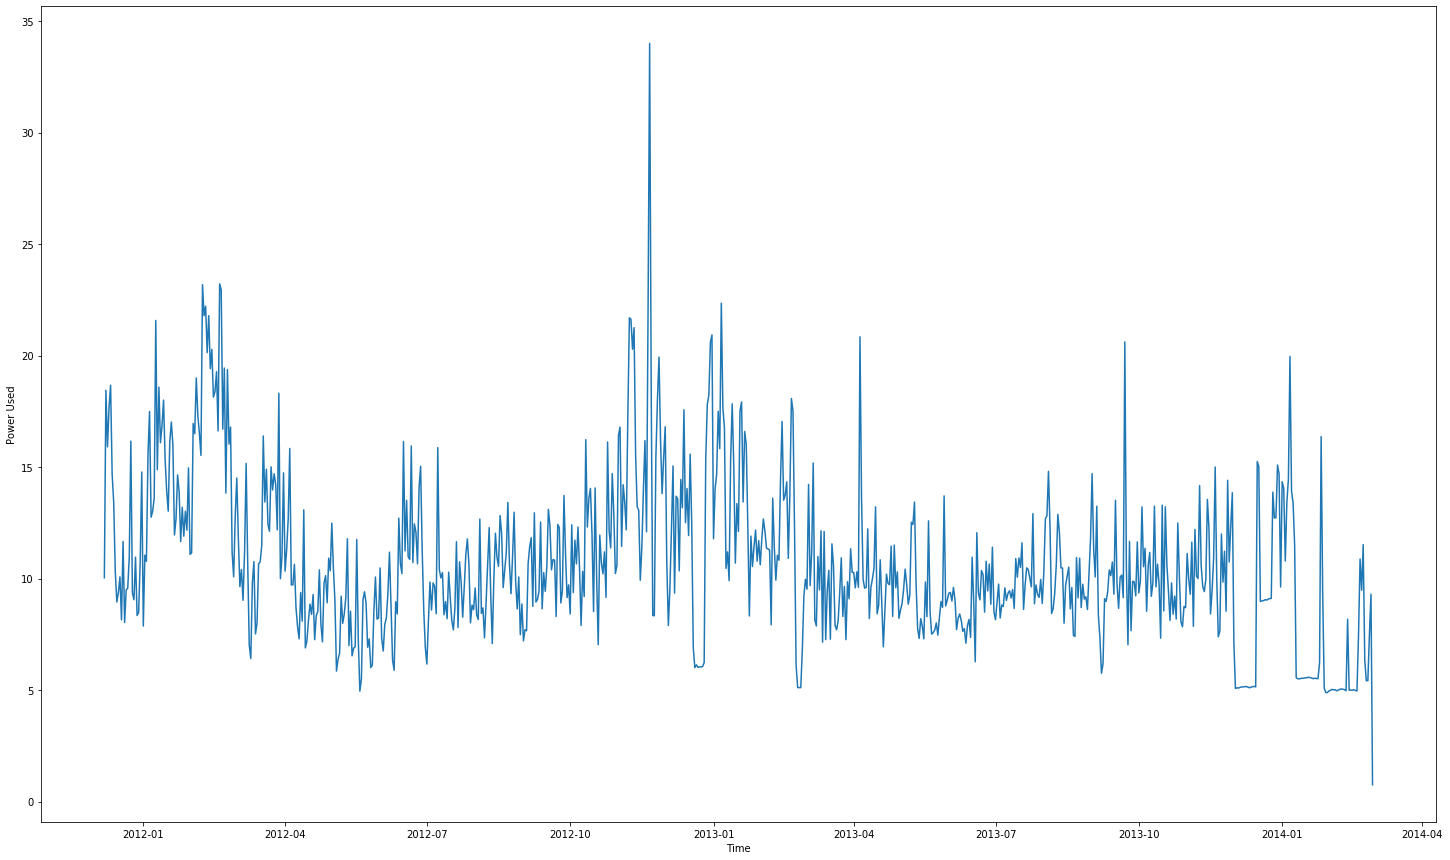

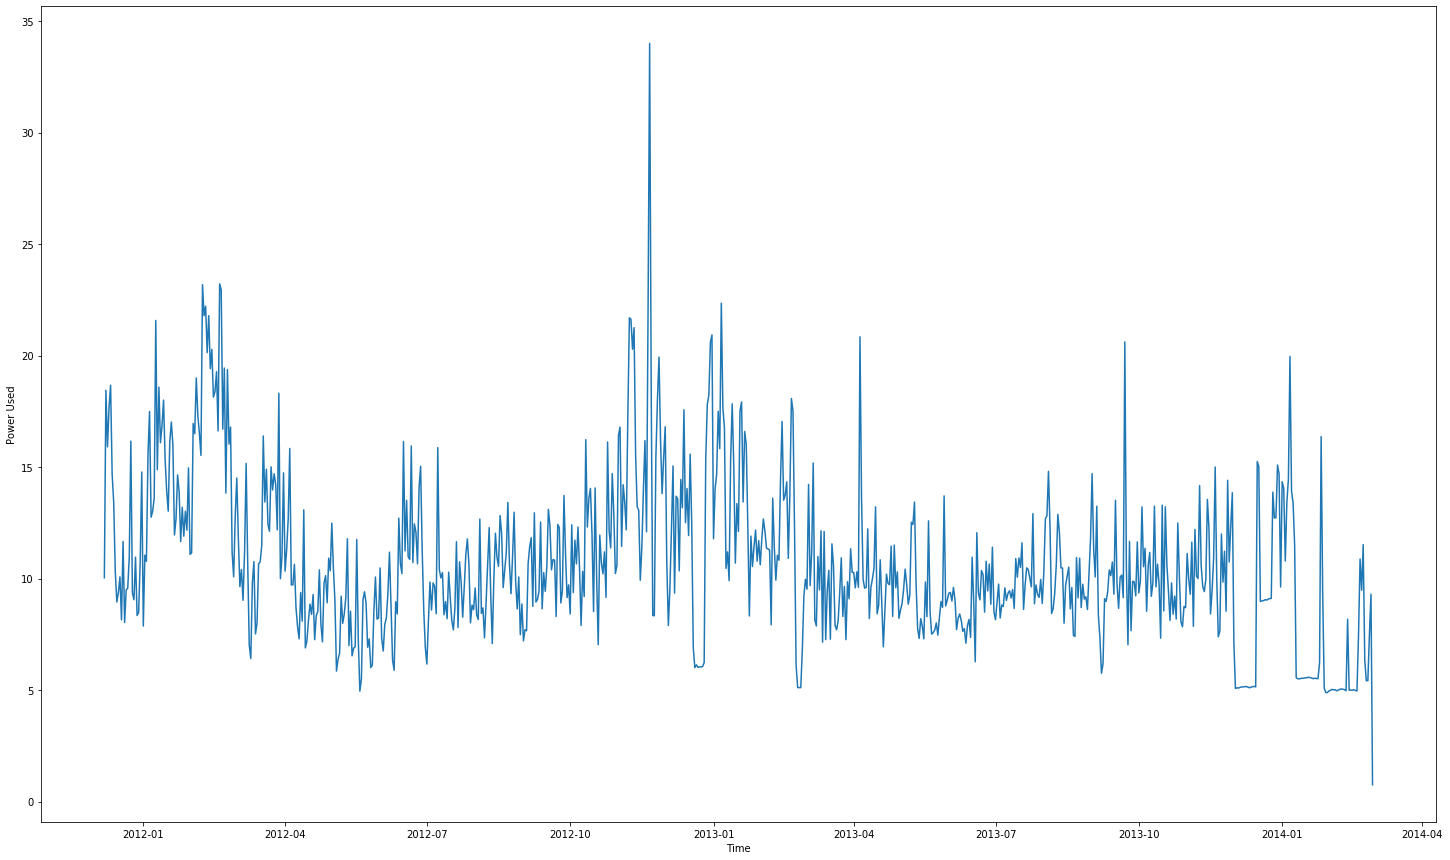

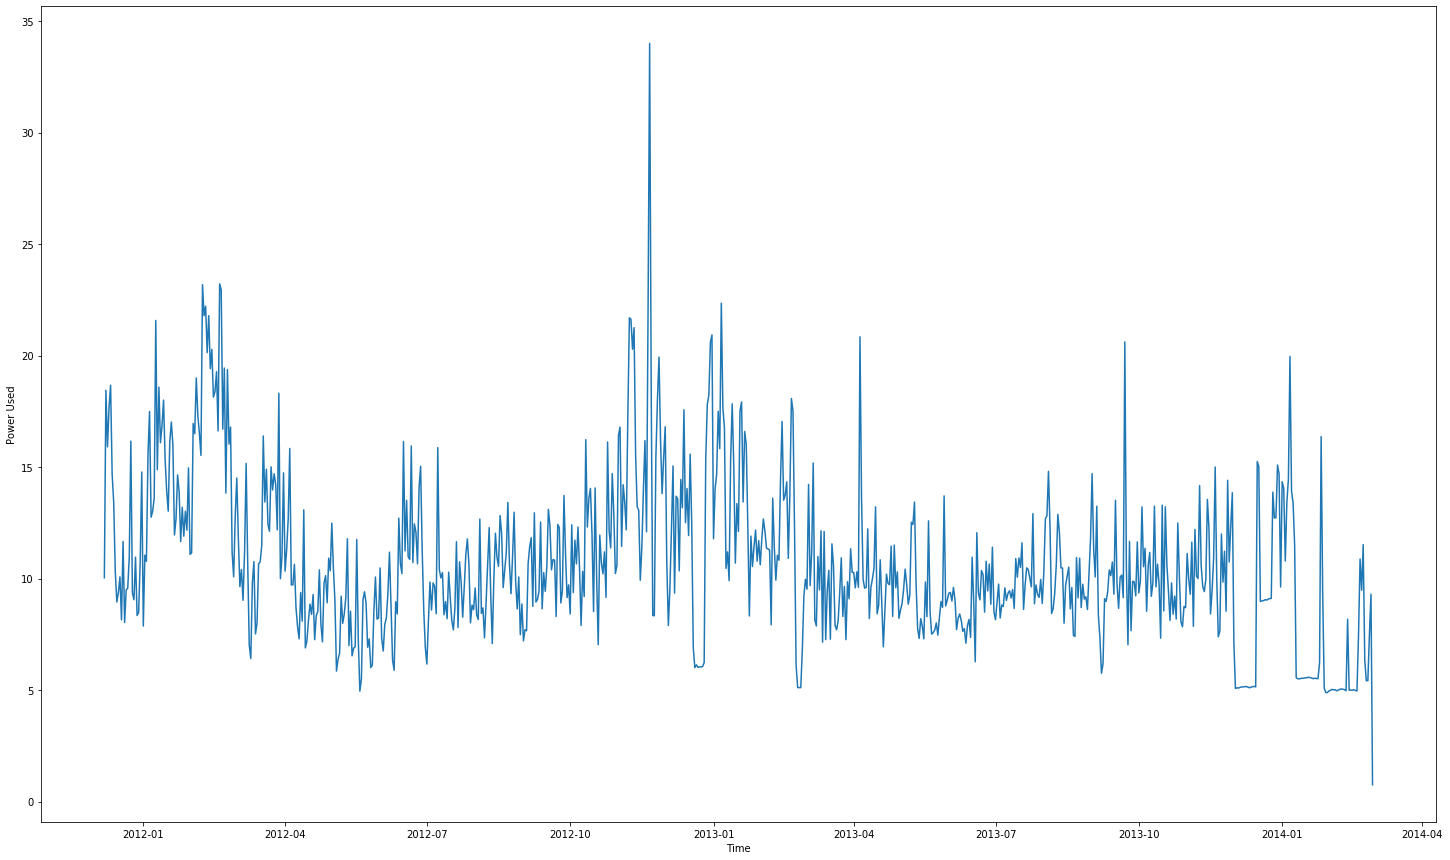

In [18]:
plotGraph(db_1_day)
plotGraph(db_2_day)
plotGraph(db_3_day)


In [19]:
db_1.drop('Date',axis = 1,inplace = True)
db_1.set_index('DateTime',inplace = True)
db_1.head()

,KWh
DateTime,
2011-12-07 09:30:00,0.303
2011-12-07 10:00:00,0.200
2011-12-07 10:30:00,0.218
2011-12-07 11:00:00,0.209
2011-12-07 11:30:00,0.210


In [20]:
db_2.drop('Date',axis = 1,inplace = True)
db_2.set_index('DateTime',inplace = True)
db_2.head()

,KWh
DateTime,
2011-12-07 09:30:00,0.275
2011-12-07 10:00:00,0.231
2011-12-07 10:30:00,0.204
2011-12-07 11:00:00,0.194
2011-12-07 11:30:00,0.317


In [21]:
db_3.drop('Date',axis = 1,inplace = True)
db_3.set_index('DateTime',inplace = True)
db_3.head()

,KWh
DateTime,
2011-12-07 10:00:00,0.491
2011-12-07 10:30:00,0.346
2011-12-07 11:00:00,0.473
2011-12-07 11:30:00,0.456
2011-12-07 12:00:00,0.432


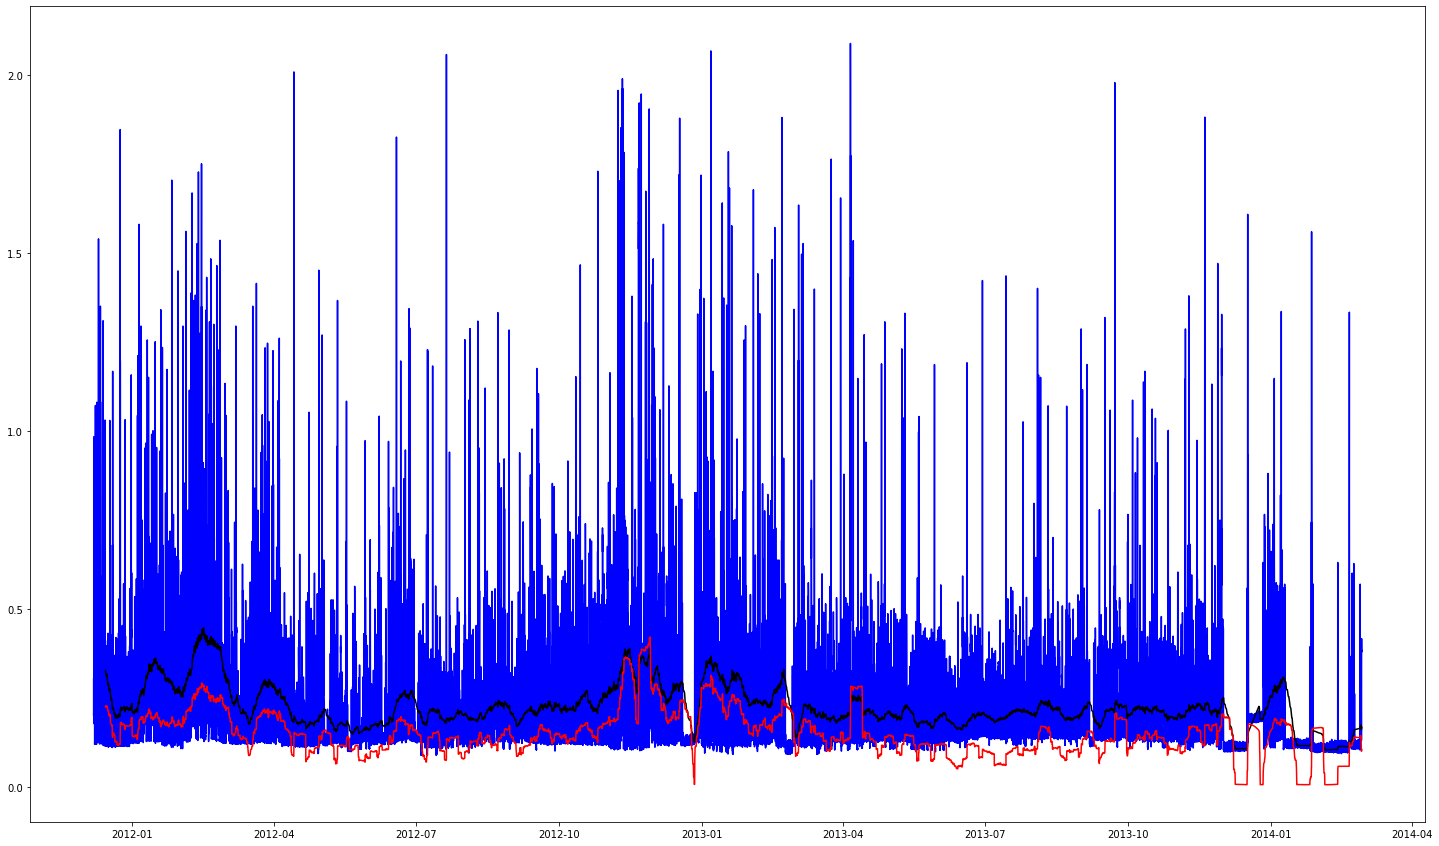

Test Stastic           -1.415570e+01
p_value                 2.123576e-26
Lags                    4.800000e+01
No of observations      3.903200e+04
Critical Value (1%)    -3.430518e+00
Critical Value (5%)    -2.861614e+00
Critical Value (10%)   -2.566809e+00
dtype: float64


In [22]:
testForStationarity(db_1)

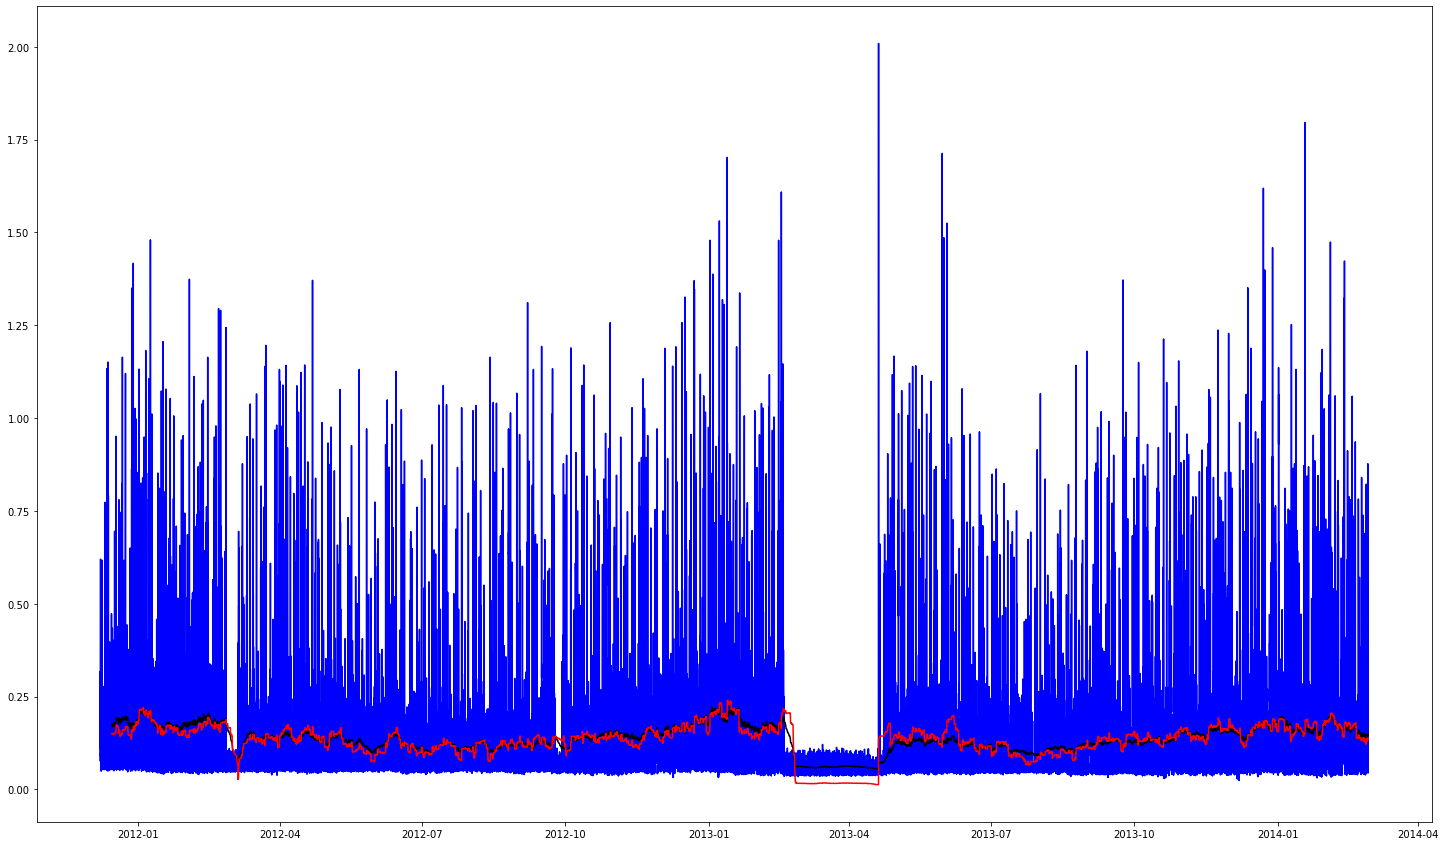

Test Stastic           -1.571035e+01
p_value                 1.361896e-28
Lags                    5.100000e+01
No of observations      3.902600e+04
Critical Value (1%)    -3.430518e+00
Critical Value (5%)    -2.861614e+00
Critical Value (10%)   -2.566809e+00
dtype: float64


In [23]:
testForStationarity(db_2)

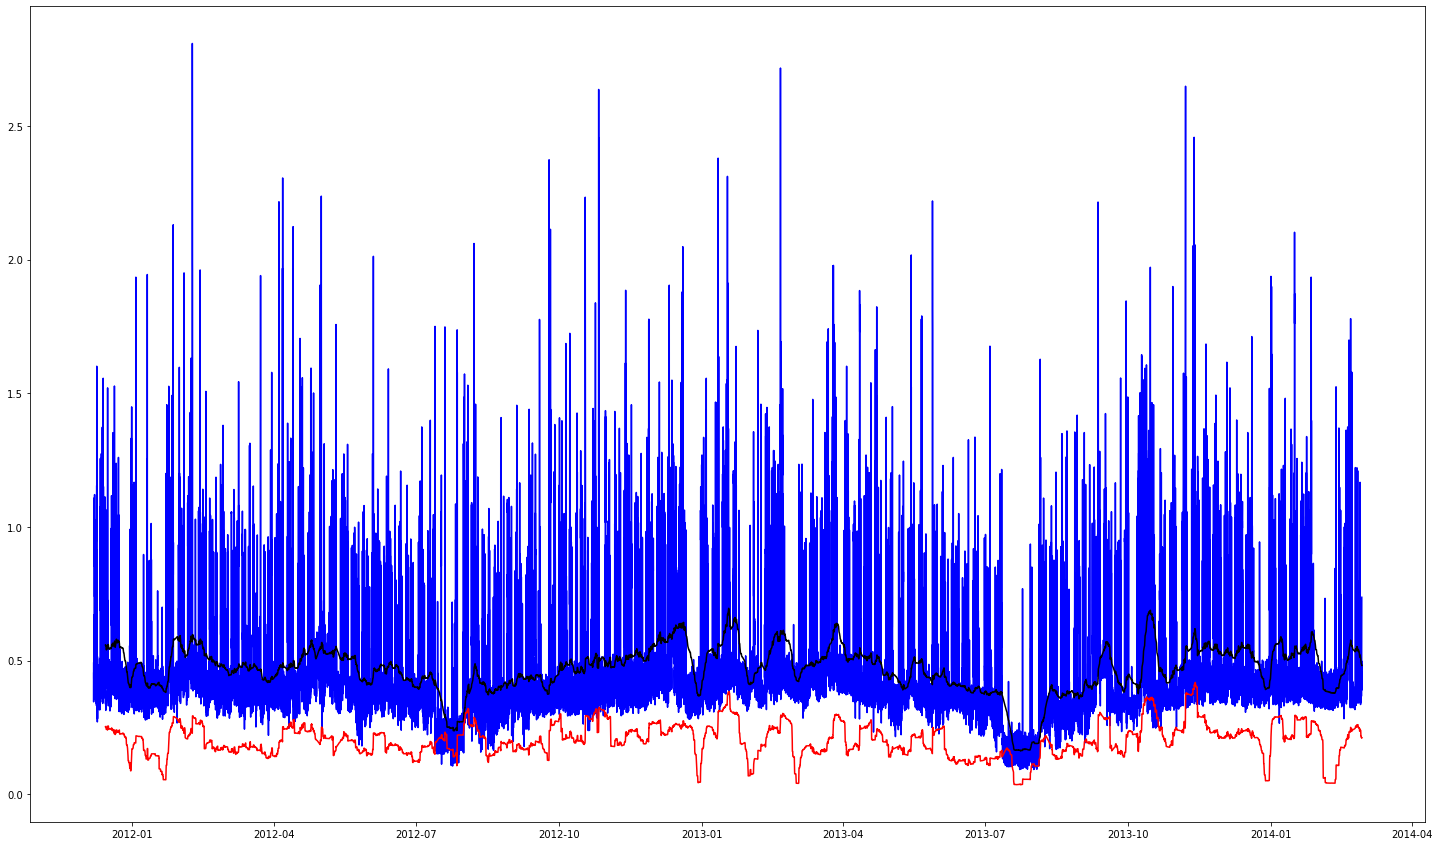

Test Stastic           -1.349557e+01
p_value                 3.046680e-25
Lags                    5.300000e+01
No of observations      3.902400e+04
Critical Value (1%)    -3.430518e+00
Critical Value (5%)    -2.861614e+00
Critical Value (10%)   -2.566809e+00
dtype: float64


In [24]:
testForStationarity(db_3)

In [26]:
db_1_logSeries = np.log(db_1)
db_2_logSeries = np.log(db_1)
db_3_logSeries = np.log(db_1)

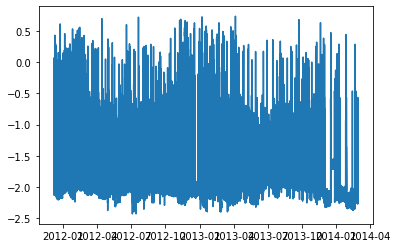

In [27]:
plt.plot(db_1_logSeries)

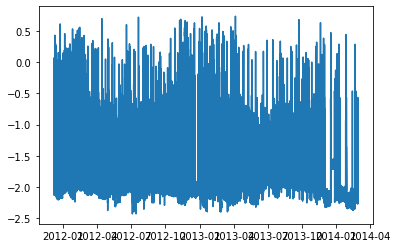

In [28]:
plt.plot(db_2_logSeries)

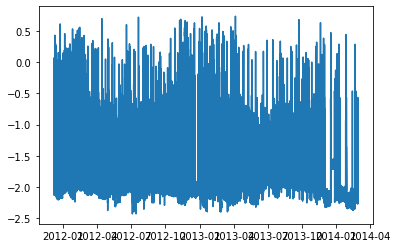

In [29]:
plt.plot(db_3_logSeries)

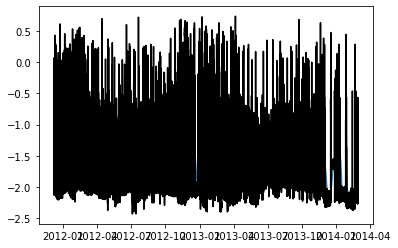

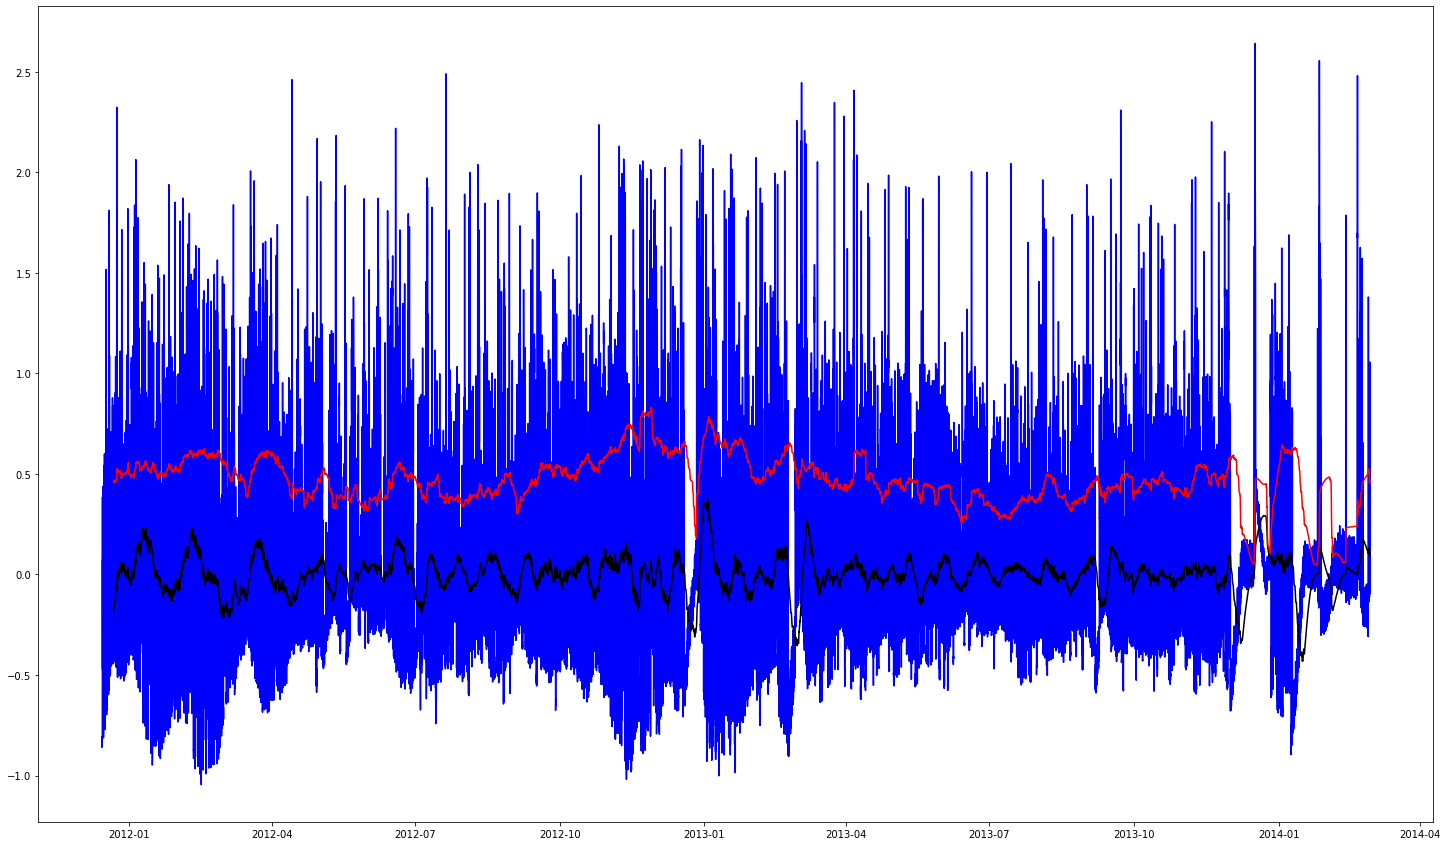

Test Stastic           -1.694714e+01
p_value                 9.521373e-30
Lags                    4.700000e+01
No of observations      3.866900e+04
Critical Value (1%)    -3.430519e+00
Critical Value (5%)    -2.861615e+00
Critical Value (10%)   -2.566810e+00
dtype: float64


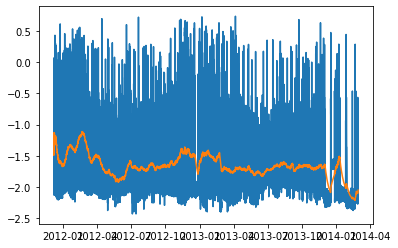

Hello


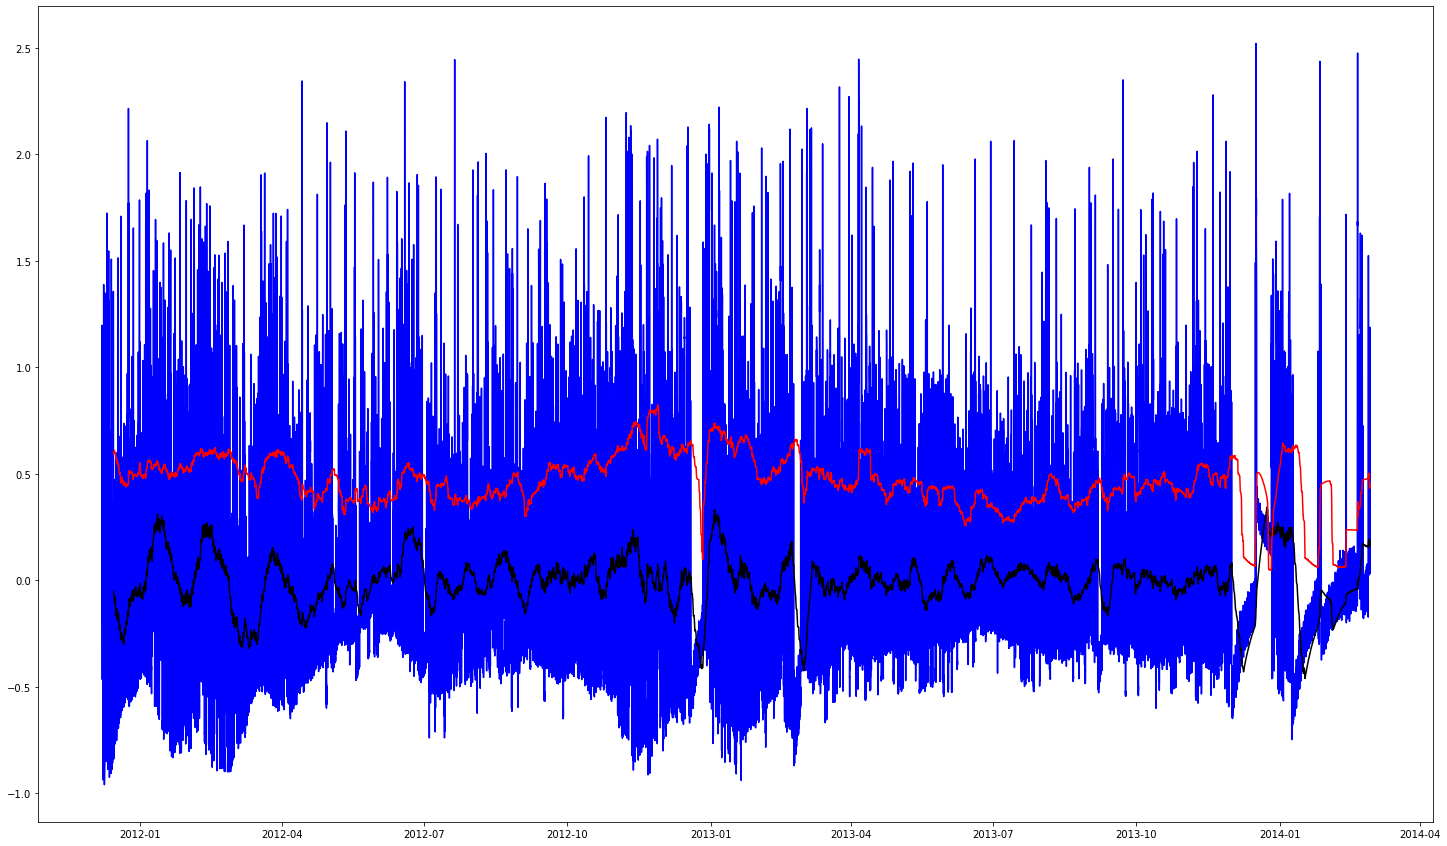

Test Stastic           -1.602354e+01
p_value                 6.166937e-29
Lags                    4.700000e+01
No of observations      3.903300e+04
Critical Value (1%)    -3.430518e+00
Critical Value (5%)    -2.861614e+00
Critical Value (10%)   -2.566809e+00
dtype: float64


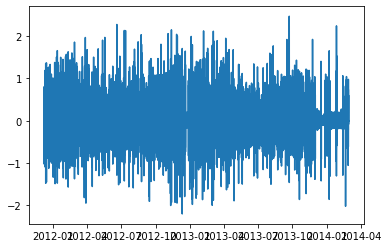

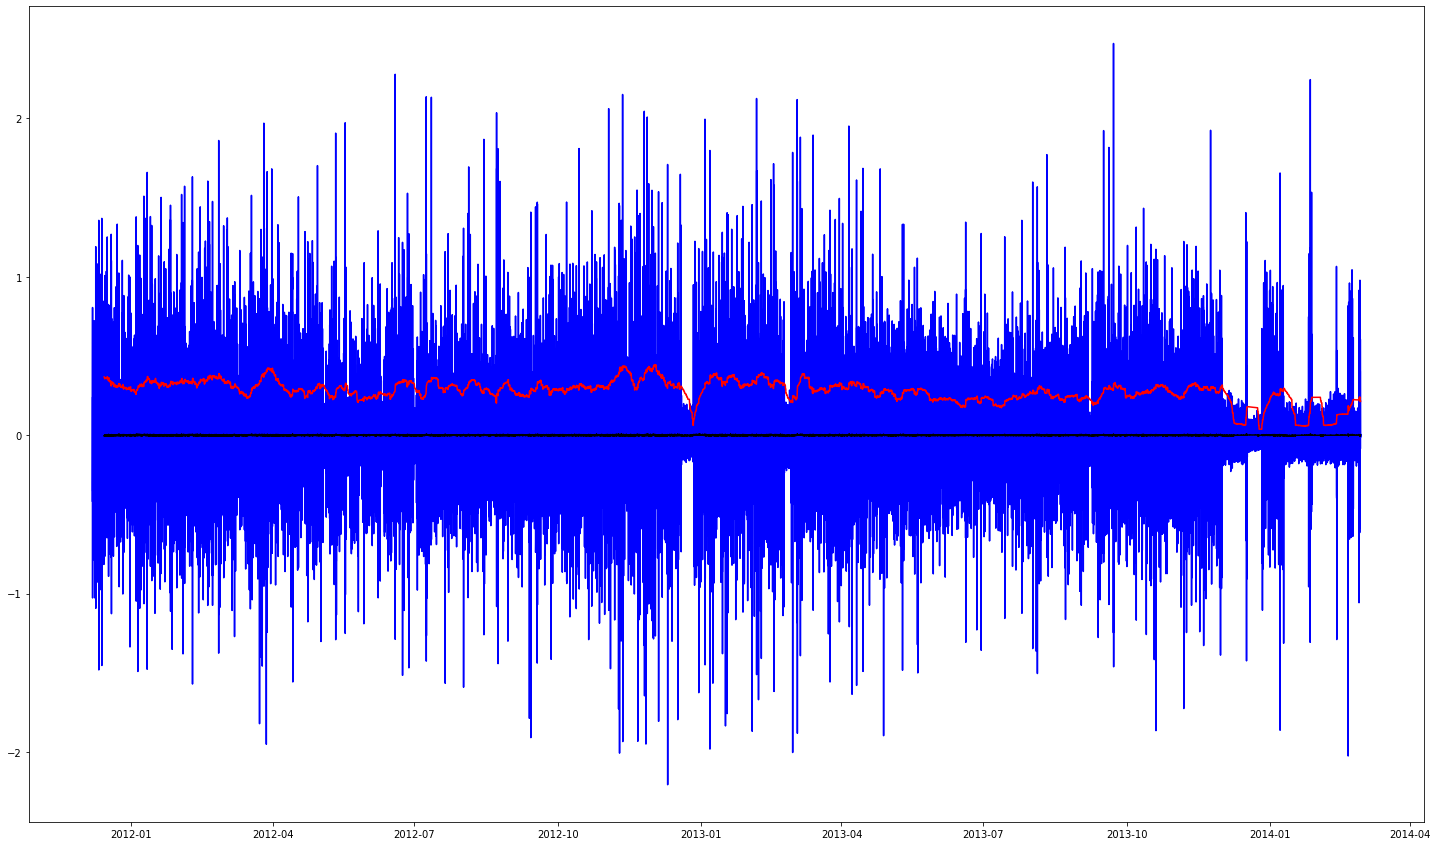

Test Stastic              -58.433457
p_value                     0.000000
Lags                       49.000000
No of observations      39030.000000
Critical Value (1%)        -3.430518
Critical Value (5%)        -2.861614
Critical Value (10%)       -2.566809
dtype: float64


In [40]:
x = transformingToStationary(db_1)

In [1]:
predictionBlock(db_1)
predictionBlock(db_2)
predictionBlock(db_3)

NameError: name 'predictionBlock' is not defined

,KWh
DateTime,
2011-12-07 09:30:00,0.303
2011-12-07 10:00:00,0.200
2011-12-07 10:30:00,0.218
2011-12-07 11:00:00,0.209
2011-12-07 11:30:00,0.210
